This notebook presents results from our study, whereby a pre-trained deep learning algorithm called CLARAN (Classifying Radio Sources Automatically with Neural Networks) by Wu et al. 2019 (source code: [https://github.com/chenwuperth/rgz_rcnn/
](http://url); reference paper: [https://doi.org/10.1093/mnras/sty2646](http://url). <br>
- Using data from deep-wide area observations from GMRT (Giant Metrewave Radio Telescope) survey at 610 MHz, done in the European Large Area ISO Survey North 1 (ELAIS N1) region. <br>
- Using catalogued radio source positions, cutouts of size 181 x 181 pixels were generated centred at those positons; this size is equivalent to 3 arcmin x 3 arcmin considering the pixel scale of the FITS images from GMRT observations.
- Using information predicted by CLARAN (i.e. the predicted class, probability and the bounding box), turned CLARAN into a fully-fledged radio source characterization pipeline, that detects, classifies and identify IR counterpart of the radio sources.

In [1]:
# Load neccessary libraries
import sys
import os, errno
import os.path as osp
import glob
import re
import math
sys.path.append('/users/cmofokeng/rgz_rcnn/tools/')

import pandas as pd
import matplotlib.pyplot as plt
plt.rc('font', family='serif', weight='bold',size=40)
plt.rc('axes',labelweight='bold',labelsize='large')
plt.rc('xtick', labelsize='large')
plt.rc('ytick', labelsize='large')


import matplotlib as mpl
import numpy as np
from astropy.io import ascii
from astropy.table import unique
from astropy.io.votable import parse_single_table
from regions import DS9Parser
from regions import read_ds9, write_ds9, Shape

from astropy.coordinates import SkyCoord
from scipy.ndimage.measurements import center_of_mass

import matplotlib.patches as patches

from astropy.wcs import WCS
from astropy.io import fits
from fuse_radio_ir import fuse
import matplotlib.image as image
from IPython.display import display, Image
from matplotlib.ticker import AutoMinorLocator, FormatStrFormatter

import cv2
%matplotlib inline

In [2]:
def non_max_suppression_fast(boxes, overlapThresh):
	# if there are no boxes, return an empty list
	if len(boxes) == 0:
		return []
 
	# if the bounding boxes integers, convert them to floats --
	# this is important since we'll be doing a bunch of divisions
	if boxes.dtype.kind == "i":
		boxes = boxes.astype("float")
 
	# initialize the list of picked indexes	
	pick = []
 
	# grab the coordinates of the bounding boxes
	x1 = boxes[:,0]
	y1 = boxes[:,1]
	x2 = boxes[:,2]
	y2 = boxes[:,3]
 
	# compute the area of the bounding boxes and sort the bounding
	# boxes by the bottom-right y-coordinate of the bounding box
	area = (x2 - x1 + 1) * (y2 - y1 + 1)
	idxs = np.argsort(y2)
 
	# keep looping while some indexes still remain in the indexes
	# list
	while len(idxs) > 0:
		# grab the last index in the indexes list and add the
		# index value to the list of picked indexes
		last = len(idxs) - 1
		i = idxs[last]
		pick.append(i)
 
		# find the largest (x, y) coordinates for the start of
		# the bounding box and the smallest (x, y) coordinates
		# for the end of the bounding box
		xx1 = np.maximum(x1[i], x1[idxs[:last]])
		yy1 = np.maximum(y1[i], y1[idxs[:last]])
		xx2 = np.minimum(x2[i], x2[idxs[:last]])
		yy2 = np.minimum(y2[i], y2[idxs[:last]])
 
		# compute the width and height of the bounding box
		w = np.maximum(0, xx2 - xx1 + 1)
		h = np.maximum(0, yy2 - yy1 + 1)
 
		# compute the ratio of overlap
		overlap = (w * h) / area[idxs[:last]]
		print(overlap)
 
		# delete all indexes from the index list that have
		idxs = np.delete(idxs, np.concatenate(([last],
			np.where(overlap > overlapThresh)[0])))
 
    # return only the bounding boxes that were picked using the
	# integer data type
	return pick #.astype("int")
	#return boxes[pick]#.astype("int")
    #return pick#.astype("int")

In [3]:
def py_cpu_nms(dets, thresh):
    """Pure Python NMS baseline."""
    x1 = dets[:, 0]
    y1 = dets[:, 1]
    x2 = dets[:, 2]
    y2 = dets[:, 3]
    scores = dets[:, 4]

    areas = (x2 - x1 + 1) * (y2 - y1 + 1)
    order = scores.argsort()[::-1]
    #print(order)
    keep = []
    ious = []
    while order.size > 0:
        i = order[0]
        keep.append(i)
        xx1 = np.maximum(x1[i], x1[order[1:]])
        yy1 = np.maximum(y1[i], y1[order[1:]])
        xx2 = np.minimum(x2[i], x2[order[1:]])
        yy2 = np.minimum(y2[i], y2[order[1:]])
        w = np.maximum(0.0, xx2 - xx1 + 1)
        h = np.maximum(0.0, yy2 - yy1 + 1)
        inter = w * h
        ovr = inter / (areas[i] + areas[order[1:]] - inter)
        #ious.append(ovr)

        inds = np.where(ovr <= thresh)[0]
        order = order[inds + 1]

    return keep#,ious

In [4]:
def hosts_overlay(x,y,xo,yo,theta): #rotate x,y around xo,yo by theta (rad)
    xr=np.cos(theta)*(x-xo)-np.sin(theta)*(y-yo)   + xo
    yr=np.sin(theta)*(x-xo)+np.cos(theta)*(y-yo)  + yo
    return np.array([xr,yr])

In [5]:
MAX_REJECT = 0.5
MIN_NPIXELS = 5
GOOD_PIXEL = 0
BAD_PIXEL = 1
KREJ = 2.5
MAX_ITERATIONS = 5

def zscale (image, nsamples=1000, contrast=0.25, bpmask=None, zmask=None):
    """Implement IRAF zscale algorithm
    nsamples=1000 and contrast=0.25 are the IRAF display task defaults
    bpmask and zmask not implemented yet
    image is a 2-d numpy array
    returns (z1, z2)
    """

    # Sample the image
    samples = zsc_sample (image, nsamples, bpmask, zmask)
    npix = len(samples)
    samples.sort()
    zmin = samples[0]
    zmax = samples[-1]
    # For a zero-indexed array
    center_pixel = (npix - 1) // 2
    if npix%2 == 1:
        median = samples[center_pixel]
    else:
        median = 0.5 * (samples[center_pixel] + samples[center_pixel + 1])

    #
    # Fit a line to the sorted array of samples
    minpix = max(MIN_NPIXELS, int(npix * MAX_REJECT))
    ngrow = max (1, int (npix * 0.01))
    ngoodpix, zstart, zslope = zsc_fit_line (samples, npix, KREJ, ngrow,
                                             MAX_ITERATIONS)

    if ngoodpix < minpix:
        z1 = zmin
        z2 = zmax
    else:
        if contrast > 0: zslope = zslope / contrast
        z1 = max (zmin, median - (center_pixel - 1) * zslope)
        z2 = min (zmax, median + (npix - center_pixel) * zslope)
    return z1, z2

def zsc_sample (image, maxpix, bpmask=None, zmask=None):
    
    # Figure out which pixels to use for the zscale algorithm
    # Returns the 1-d array samples
    # Don't worry about the bad pixel mask or zmask for the moment
    # Sample in a square grid, and return the first maxpix in the sample
    nc = image.shape[0]
    nl = image.shape[1]
    stride = max (1.0, math.sqrt((nc - 1) * (nl - 1) / float(maxpix)))
    stride = int (stride)
    samples = image[::stride,::stride].flatten()
    return samples[:maxpix]
    
def zsc_fit_line (samples, npix, krej, ngrow, maxiter):

    #
    # First re-map indices from -1.0 to 1.0
    xscale = 2.0 / (npix - 1)
    xnorm = np.arange(npix)
    xnorm = xnorm * xscale - 1.0

    ngoodpix = npix
    minpix = max (MIN_NPIXELS, int (npix*MAX_REJECT))
    last_ngoodpix = npix + 1

    # This is the mask used in k-sigma clipping.  0 is good, 1 is bad
    badpix = np.zeros(npix, dtype="int32")

    #
    #  Iterate

    for niter in range(maxiter):

        if (ngoodpix >= last_ngoodpix) or (ngoodpix < minpix):
            break
        
        # Accumulate sums to calculate straight line fit
        goodpixels = np.where(badpix == GOOD_PIXEL)
        sumx = xnorm[goodpixels].sum()
        sumxx = (xnorm[goodpixels]*xnorm[goodpixels]).sum()
        sumxy = (xnorm[goodpixels]*samples[goodpixels]).sum()
        sumy = samples[goodpixels].sum()
        sum = len(goodpixels[0])

        delta = sum * sumxx - sumx * sumx
        # Slope and intercept
        intercept = (sumxx * sumy - sumx * sumxy) / delta
        slope = (sum * sumxy - sumx * sumy) / delta
        
        # Subtract fitted line from the data array
        fitted = xnorm*slope + intercept
        flat = samples - fitted

        # Compute the k-sigma rejection threshold
        ngoodpix, mean, sigma = zsc_compute_sigma (flat, badpix, npix)

        threshold = sigma * krej

        # Detect and reject pixels further than k*sigma from the fitted line
        lcut = -threshold
        hcut = threshold
        below = np.where(flat < lcut)
        above = np.where(flat > hcut)

        badpix[below] = BAD_PIXEL
        badpix[above] = BAD_PIXEL
        
        # Convolve with a kernel of length ngrow
        kernel = np.ones(ngrow,dtype="int32")
        badpix = np.convolve(badpix, kernel, mode='same')

        ngoodpix = len(np.where(badpix == GOOD_PIXEL)[0])
        
        niter += 1

    # Transform the line coefficients back to the X range [0:npix-1]
    zstart = intercept - slope
    zslope = slope * xscale

    return ngoodpix, zstart, zslope

def zsc_compute_sigma (flat, badpix, npix):

    # Compute the rms deviation from the mean of a flattened array.
    # Ignore rejected pixels

    # Accumulate sum and sum of squares
    goodpixels = np.where(badpix == GOOD_PIXEL)
    sumz = flat[goodpixels].sum()
    sumsq = (flat[goodpixels]*flat[goodpixels]).sum()
    ngoodpix = len(goodpixels[0])
    if ngoodpix == 0:
        mean = None
        sigma = None
    elif ngoodpix == 1:
        mean = sumz
        sigma = None
    else:
        mean = sumz / ngoodpix
        temp = sumsq / (ngoodpix - 1) - sumz*sumz / (ngoodpix * (ngoodpix - 1))
        if temp < 0:
            sigma = 0.0
        else:
            sigma = math.sqrt (temp)

    return ngoodpix, mean, sigma

In [6]:
def ds9_coords(lc_x,lc_y,uc_x,uc_y,wcs):
    
    lb = SkyCoord(lc_x,lc_y, frame='icrs', unit ='deg')
    ub = SkyCoord(uc_x,uc_y, frame='icrs', unit ='deg')
    
    lb = lb.to_pixel(wcs)
    ub = ub.to_pixel(wcs)
    
    width = (ub[0] - lb[0])
    height = (ub[1] - lb[1])
    
    y1_flip = hosts_overlay(0,lb[1],181/2,181/2,-np.pi)
    y2_flip = hosts_overlay(0,ub[1],181/2,181/2,-np.pi)
    

    ave_x = (lb[0]+ub[0])/2
    ave_y = (y2_flip[1]+y1_flip[1])/2
    
    poss = SkyCoord.from_pixel(ave_x-1,ave_y,wcsradio)
    poss =  [float(x) for x in poss.to_string().split()]
    
    return poss[0],poss[1],height,width

### Loading catalogues

In [7]:
data_dir = "/idia/users/cmofokeng/data/gmrt/" 

output_dir = osp.join(data_dir,"output_gmrt")  # Output files from the adapted CLARAN

# load catalogues to a Dataframe
data_D1 = pd.read_csv(osp.join(output_dir,"ClaRAN_D1_final_catalogue_v4.csv"))
data_D4 = pd.read_csv(osp.join(output_dir,"ClaRAN_D4_final_catalogue_v5.csv"))

In [100]:
# load the original gmrt catalog (using PyBDSF source extraction algorithm)
table = parse_single_table("/idia/users/cmofokeng/data/gmrt/en1w610-5sg9-clean-offset.vot")
data = table.to_table(use_names_over_ids=True)

In [101]:
noclass_fits_D1 = []
        
for i in range(len(data)):
    
    if not data['Source_id'][i] in pd.unique(data_D1['Source_ID']):
        noclass_fits_D1.append([i])

In [102]:
noclass_fits_D4 = []
        
for i in range(len(data)):
    
    if not data['Source_id'][i] in pd.unique(data_D4['Source_ID']):
        noclass_fits_D4.append([i])

In [103]:
noclass_D1 = data[noclass_fits_D1]
noclass_D4 = data[noclass_fits_D4]

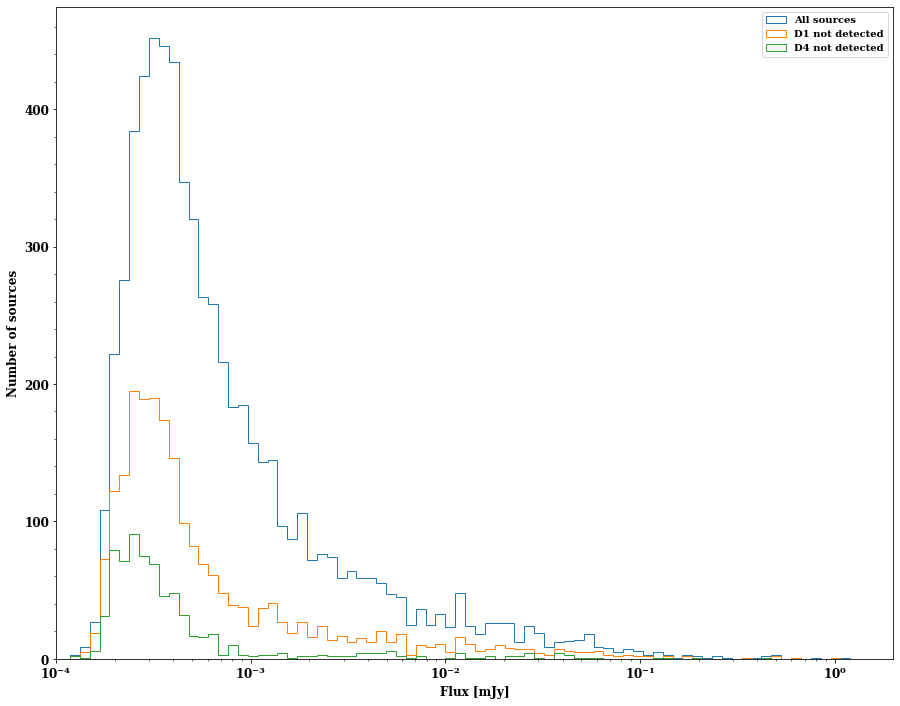

In [105]:
plt.figure(figsize=(15,12))
plt.minorticks_on()
n, bins, patches = plt.hist(data['Total_flux'],label='All sources',bins=np.logspace(np.log(min(data['Total_flux'])),np.log(max(data['Total_flux'])), 180),histtype='step')
plt.hist(noclass_D1['Total_flux'],label='D1 not detected',bins=bins,histtype='step')
plt.hist(noclass_D4['Total_flux'],label='D4 not detected',bins=bins,histtype='step')
plt.ylabel('Number of sources')
plt.xlim(10e-5,10**0.3)
plt.xlabel('Flux [mJy]')
plt.xscale('log')
plt.legend(loc='upper right')

In [8]:
# number of images (or detections)
len(data_D1),len(data_D4)

(7896, 11501)

Source positions from PyBDSF were used to create the dataset used - which had 6,400 source positions (Ishwara-Chandra et al., 2020) around which images of size 3 arcmin (181 pixels) were created. The dataset used contains 6,400 images. Due to this process of data generation, sources in crowded fields are observed in more than one cutout, that explains the high of images (or detections), for both datasets, shown above.

In [9]:
data_D1["Source_ID"].nunique(),data_D4["Source_ID"].nunique()

(4212, 5701)

From the 6,400 cutouts generated, the final output datasets for the D1 and the D4 are 4,212 and 5,701 from which over 7,000 and 11,000 detections were made from those cutouts respectively.

In [10]:
data_D1.head() # print top 5 rows of the dataframe

Source_ID  Class  Scores        x1       y1        x2       y2     RC_RA  \
0       5702  1C_1P  0.9534  241.3987  55.6404  241.3937  55.6432  241.3960   
1       4755  1C_1P  0.9942  242.2805  54.5658  242.2731  54.5702  242.2768   
2       6181  1C_1P  0.9136  240.8764  55.4561  240.8709  55.4591  240.8745   
3       6181  1C_1P  0.9091  240.9000  55.4421  240.8953  55.4448  240.8980   
4       6181  3C_3P  0.9563  240.9008  55.4344  240.8538  55.4604  240.8711   

    RC_Dec  PyBDSF_RA  PyBDSF_Dec  
0  55.6416   241.3961     55.6413  
1  54.5677   242.2768     54.5677  
2  55.4574   240.8979     55.4435  
3  55.4432   240.8979     55.4435  
4  55.4418   240.8979     55.4435

In [11]:
data_D4.head() # print top 5 rows of the dataframe

Source_ID  Class  Scores        x1       y1        x2       y2     RC_RA  \
0       5027  1C_1P  0.9962  242.0214  54.8451  242.0133  54.8500  242.0167   
1       5027  1C_1P  0.9941  242.0537  54.8609  242.0495  54.8635  242.0511   
2       5027  1C_1P  0.9701  242.0415  54.8541  242.0383  54.8561  242.0405   
3       5570  1C_1P  0.9918  241.6407  53.4754  241.6300  53.4817  241.6359   
4       5570  1C_1P  0.9729  241.6346  53.4590  241.6317  53.4608  241.6335   

    RC_Dec  PyBDSF_RA  PyBDSF_Dec  
0  54.8470   242.0490     54.8658  
1  54.8618   242.0490     54.8658  
2  54.8548   242.0490     54.8658  
3  53.4779   241.6331     53.4602  
4  53.4601   241.6331     53.4602

In [12]:
radio_file = 'gmrt_en1w610_clipped.fits'
hdu = fits.open(radio_file)[0]
wcsradio = WCS(hdu.header, naxis=2)

# convert coordinates of the boxes (from degrees) to sky coordinates
ul = SkyCoord(data_D1['x1'],data_D1['y1'],frame='fk5',unit='deg')
lr = SkyCoord(data_D1['x2'],data_D1['y1'],frame='fk5',unit='deg')

# convert these sky coordinates to pixels using wcs information
ul_pix = ul.to_pixel(wcsradio)
    
lr_pix = lr.to_pixel(wcsradio)

w = abs(ul_pix[0]-lr_pix[0])
h = abs(ul_pix[1]-lr_pix[1])

In [13]:
# calculate separation between coordinates of the box
sep = ul.separation(lr)

(array([5.636e+03, 5.110e+02, 4.490e+02, 3.410e+02, 4.780e+02, 3.450e+02,
        1.070e+02, 2.100e+01, 5.000e+00, 3.000e+00]),
 array([  6.81004511,  21.42004316,  36.03004121,  50.64003926,
         65.2500373 ,  79.86003535,  94.4700334 , 109.08003145,
        123.69002949, 138.30002754, 152.91002559]),
 <BarContainer object of 10 artists>)

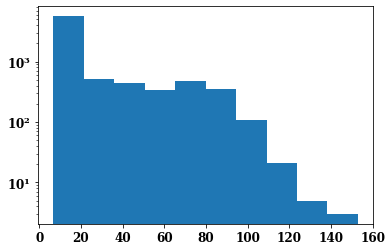

In [14]:
plt.hist(sep.arcsec,log=True)

(array([5.636e+03, 5.110e+02, 4.490e+02, 3.410e+02, 4.780e+02, 3.450e+02,
        1.070e+02, 2.100e+01, 5.000e+00, 3.000e+00]),
 array([  6.80497896,  21.41484794,  36.02471692,  50.6345859 ,
         65.24445488,  79.85432386,  94.46419284, 109.07406182,
        123.6839308 , 138.29379978, 152.90366876]),
 <BarContainer object of 10 artists>)

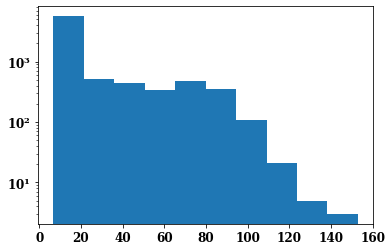

In [15]:
plt.hist(w,log=True)

(array([6.031e+03, 9.770e+02, 3.650e+02, 2.580e+02, 1.480e+02, 7.900e+01,
        2.700e+01, 7.000e+00, 2.000e+00, 2.000e+00]),
 array([4.40103358e-05, 4.95622771e-01, 9.91201531e-01, 1.48678029e+00,
        1.98235905e+00, 2.47793781e+00, 2.97351657e+00, 3.46909533e+00,
        3.96467409e+00, 4.46025285e+00, 4.95583161e+00]),
 <BarContainer object of 10 artists>)

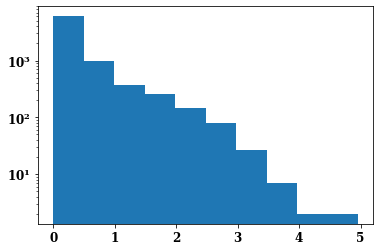

In [16]:
plt.hist(h,log=True)

As shown by the histograms above, all the boxes have sizes within the allowed range (< 181 pixels)

In [17]:
data_D1["Source_ID"].nunique(),data_D4["Source_ID"].nunique()

(4212, 5701)

In [18]:
# printing number of predictions per class in each dataset

In [19]:
print("1C_1P - (D1, D4) : ({},{})".format(len(np.where(data_D1['Class']=='1C_1P')[0]),len(np.where(data_D4['Class']=='1C_1P')[0])))

1C_1P - (D1, D4) : (5877,10651)


In [20]:
print("1C_2P - (D1, D4) : ({},{})".format(len(np.where(data_D1['Class']=='1C_2P')[0]),len(np.where(data_D4['Class']=='1C_2P')[0])))

1C_2P - (D1, D4) : (73,174)


In [21]:
print("1C_3P - (D1, D4) : ({},{})".format(len(np.where(data_D1['Class']=='1C_3P')[0]),len(np.where(data_D4['Class']=='1C_3P')[0])))

1C_3P - (D1, D4) : (48,107)


In [22]:
print("2C_2P - (D1, D4) : ({},{})".format(len(np.where(data_D1['Class']=='2C_2P')[0]),len(np.where(data_D4['Class']=='2C_2P')[0])))

2C_2P - (D1, D4) : (249,253)


In [23]:
print("2C_3P - (D1, D4) : ({},{})".format(len(np.where(data_D1['Class']=='2C_3P')[0]),len(np.where(data_D4['Class']=='2C_3P')[0])))

2C_3P - (D1, D4) : (23,33)


In [24]:
print("3C_3P - (D1, D4) : ({},{})".format(len(np.where(data_D1['Class']=='3C_3P')[0]),len(np.where(data_D4['Class']=='3C_3P')[0])))

3C_3P - (D1, D4) : (1626,283)


In [25]:
def within_bbox(rc_sky,gc_sky,lin_sky):
    """Check whether boxes of given detections overlap
    
    parameters:
    rc_sky - radio source position in sky coordinates
    gc_sky - geometric centre position in sky coordinates
    sep_sky  - separation between edges of the box
    
    returns:
    indices of boxes that overlap
    """
    
    inside_bbox = []
    for i,c in enumerate(rc_sky):
        
        # separation between one rc position and all gc positions
        sep = c.separation(gc_sky)
        
        # get indices where the above separation (sep) is less than that of edges
        ix = np.where(sep.arcsecond<lin_sky[i].arcsecond/2)[0]
        
        # append indices of such separation distances
        inside_bbox.append(ix)
        
    return inside_bbox

In [26]:
def sky_separation(rc1,rc2,x1,x2,y1,y2):
    """Calculate the sky separation between sky coordinates and also return a set of coordinates
    
    parameters:
    rc1,rc2 - radio centre coordinates in degrees
    x1,x2,y1,y2 - corrdinates of the edges of the box
    
    returns:
    rc - radio centre positions in sky coordinates
    gc - geometric centre position in sky coordinates
    sep - separation between the edges of the box
    """
    # radio centre position in sky coords
    rc = SkyCoord(rc1,rc2, frame='fk5',unit='deg')
    
    # average position of the edges of the box
    x = (x1+x2)*0.5
    y = (y1+y2)*0.5
    
    # average position (gc - geometric centre) in sky coords
    gc = SkyCoord(x,y,frame='fk5',unit='deg')
    
    # edges of the box in sky coords
    ul = SkyCoord(x1,y1,frame='fk5',unit='deg')
    lr = SkyCoord(x2,y2,frame='fk5',unit='deg')
    
    # separation between edges of the box
    sep = lr.separation(ul)
    
    return rc, gc, sep

In [27]:
rc_sky, gc_sky, linear_sep = sky_separation(data_D4["RC_RA"].to_numpy(),data_D4["RC_Dec"].to_numpy(),
                                            data_D4["x1"].to_numpy(),data_D4["x2"].to_numpy(),
                                            data_D4["y1"].to_numpy(),data_D4["y2"].to_numpy())

overlap_D4 = within_bbox(rc_sky,gc_sky,linear_sep)

In [28]:
overlap_D4

[array([0]),
 array([1]),
 array([2]),
 array([3]),
 array([4]),
 array([4, 5]),
 array([6]),
 array([7]),
 array([   8, 5952, 8910]),
 array([9]),
 array([10]),
 array([11]),
 array([12]),
 array([13]),
 array([  14, 9507]),
 array([  15, 9508]),
 array([  16, 9509]),
 array([17]),
 array([18]),
 array([19]),
 array([  20, 4184]),
 array([21]),
 array([22]),
 array([23]),
 array([24]),
 array([25]),
 array([26]),
 array([27]),
 array([28]),
 array([29]),
 array([  30, 1592]),
 array([31]),
 array([  32, 1595]),
 array([33]),
 array([  34, 8756]),
 array([  35, 8758]),
 array([  36, 8757]),
 array([37]),
 array([38]),
 array([39]),
 array([40]),
 array([  41, 2566, 7772]),
 array([42]),
 array([43, 45]),
 array([44]),
 array([43, 45]),
 array([46]),
 array([47]),
 array([48]),
 array([49]),
 array([50]),
 array([51]),
 array([52]),
 array([53]),
 array([54]),
 array([55]),
 array([56]),
 array([57]),
 array([58]),
 array([59]),
 array([60]),
 array([61]),
 array([62]),
 array([63]),
 a

In [29]:
rc_sky, gc_sky, linear_sep = sky_separation(data_D1["RC_RA"].to_numpy(),data_D1["RC_Dec"].to_numpy(),
                                            data_D1["x1"].to_numpy(),data_D1["x2"].to_numpy(),
                                            data_D1["y1"].to_numpy(),data_D1["y2"].to_numpy())

overlap_D1 = within_bbox(rc_sky,gc_sky,linear_sep)

In [30]:
def unique_detections(df,overlapping_bbox):
    """A function to suppress overlapping boxes
    
    parameters:
    df - dataframe of predictions
    overlapping_bbox - overlapping boxes from the dataframe
    
    returns:
    keep - a list of indices of "unique" boxes
    """
    
    # list to keep unique boxes
    keep = []
    for i in range(len(overlapping_bbox)):
        # overlap_bbox is an array of indices of overlapping box in our original dataframe (df) 
        if len(overlapping_bbox[i])>1:
            # get all the indices that have overlapping boxes
            inds = overlapping_bbox[i]
            # get this sample from the dataframe
            bbox = df.iloc[inds]
            # the assumption is that boxes with same the class prediction 
            # represent the same source(s) and therefore are suppressed 
            # by taking the prediction with the highest probability
            
            # get unique classes
            cl_unique = np.unique(bbox["Class"].to_numpy())
            
            for cl in cl_unique:
                
                # get predictions with the same class
                same = bbox[bbox["Class"]==cl]
                
#                 s = same.iloc[0]
                
#                 # RC coordinates
#                 rc_sky = SkyCoord(s["RC_RA"],s["RC_Dec"],frame='fk5',unit='deg')
                
#                 # RC positions for all predictions
#                 rc_all_sky = SkyCoord(same["RC_RA"],same["RC_Dec"],frame='fk5',unit='deg')
                
#                 # distance separation between one RC coords and all RC coords
#                 dis_sep = rc_sky.separation(rc_all_sky).arcsec
                
                
#                 # box coordinates
#                 bbox1 = SkyCoord(s["x1"],s["y1"],frame='fk5',unit='deg')
#                 bbox2 = SkyCoord(s["x2"],s["y2"],frame='fk5',unit='deg')
                
#                 # distance separation between box coordinates
#                 d = bbox2.separation(bbox1).arcsec
                
#                 # all  the overlpping boxes within half of the radial distance
#                 r = d/2
                
#                 # get overlapping boxes
#                 ix_overlap = np.where(dis_sep<r)[0]
                
#                 # get boxes not overlapping
#                 ix_noverlap = np.where(dis_sep>=r)[0]
                
#                 # get rid boxes that are in both lists
#                 n_ix = []
#                 for j in range(len(ix_noverlap)):
#                     if ix_noverlap[j] in ix_overlap:
#                         n_ix.append(ix_noverlap[j])
                        
                
#                 # get same boxes
#                 same_boxes = same.iloc[ix_overlap]
                
#                 # other boxes 
#                 other = same.iloc[n_ix]
                
#                 # append indices 
#                 if len(other)>0:
#                     keep.append(other.index.values.tolist())
                
                
                # for overlapping boxes suppress others and take the one with the highest score
                unique_source = same[same["Scores"].to_numpy()==max(same["Scores"].to_numpy())]

                # append the unique box(es) index(ices)
                keep.append(unique_source.index.values.tolist())
                
    return keep
                

In [31]:
keep_D4 = unique_detections(data_D4,overlap_D4)
#keep_D4 = []
# for i in range(len(overlap_D4)):
#     if len(overlap_D4[i][1])>1:
#         inds = overlap_D4[i][1]
#         ex = df_D4.iloc[inds]
        
#         cl_unique = np.unique(ex["Class"].to_numpy())
        
#         for cl in cl_unique:
#             row_ex = ex[ex["Class"]==cl]
#             #for j in range(len(row_ex)):

#             row = row_ex.iloc[0]

#             rc_ex = SkyCoord(row["RC_RA"],row["RC_Dec"],frame='fk5',unit='deg')

#             ul = SkyCoord(row["x1"],row["y2"], frame='fk5',unit='deg')
#             lr = SkyCoord(row["x2"],row["y2"], frame='fk5',unit='deg')

#             d = lr.separation(ul).arcsec
#                 #print(r)
#             rc_all = SkyCoord(row_ex["RC_RA"].to_numpy(),row_ex["RC_Dec"].to_numpy(),frame='fk5',unit='deg')
#                 #gc_ex = SkyCoord(x_ex,y_ex,frame='fk5',unit='deg')
#             sep = rc_ex.separation(rc_all).arcsec
                
#             r = d/2
#             ix_fov = np.where(sep<r)[0]
#             ix_nfov = np.where(sep>=r)[0]
            
#             n_ix = []
#             for j in range(len(ix_nfov)):
#                 if ix_nfov[j] not in ix_fov:
#                     n_ix.append(j)
                        
#             #print(ix_fov,ix_nfov)
#             same_source = row_ex.iloc[ix_fov]
#             other_sources = row_ex.iloc[n_ix]

#             if len(other_sources)>0:
#                 keep_D4.append(other_sources.index.values.tolist())

#             unique_source = same_source[same_source["Scores"].to_numpy()==max(same_source["Scores"].to_numpy())]

#             keep_D4.append(unique_source.index.values.tolist())

In [32]:
keep_D4

[[4],
 [5952],
 [8],
 [14],
 [15],
 [16],
 [4184],
 [30],
 [1595],
 [8756],
 [35],
 [36],
 [2566],
 [43],
 [43],
 [65],
 [83],
 [9661],
 [92],
 [93],
 [5220],
 [4869],
 [126],
 [126],
 [132],
 [6205],
 [8985],
 [145],
 [152],
 [154],
 [156],
 [3708],
 [3711],
 [4839],
 [175],
 [1897],
 [1898],
 [1897],
 [185],
 [185],
 [188],
 [188],
 [192],
 [192],
 [194],
 [196],
 [197],
 [197],
 [10793],
 [3758],
 [218],
 [219],
 [3761],
 [218],
 [6591],
 [2827],
 [2826],
 [2828],
 [230],
 [233],
 [234],
 [236],
 [244],
 [246],
 [247],
 [247],
 [251],
 [261],
 [265],
 [7555],
 [277],
 [278],
 [5501],
 [284],
 [308],
 [309],
 [317],
 [317],
 [330],
 [332],
 [1244],
 [1245],
 [340],
 [341],
 [5847],
 [348],
 [349],
 [357],
 [7322],
 [10446],
 [6209],
 [367],
 [373],
 [2283],
 [385],
 [385],
 [389],
 [4346],
 [410],
 [410],
 [419],
 [420],
 [422],
 [5468],
 [5470],
 [8437],
 [8439],
 [9100],
 [9101],
 [2916],
 [447],
 [5653],
 [452],
 [465],
 [465],
 [469],
 [470],
 [470],
 [10032],
 [482],
 [3136],
 [

In [33]:
keep_D1 = unique_detections(data_D1,overlap_D1)
#keep_D1 = []
# for i in range(len(overlap_D1)):
#     if len(overlap_D1[i][1])>1:
#         ex = df_D4.iloc[overlap_D1[i][1]]
        
#         cl_unique = np.unique(ex["Class"].to_numpy())
#         for cl in cl_unique:

#             row = ex[ex["Class"]==cl]

#             rc_ex = SkyCoord(row["RC_RA"].iloc[0],row["RC_Dec"].iloc[0],frame='fk5',unit='deg')
            
#             ul = SkyCoord(row["x1"].iloc[0],row["y1"].iloc[0], frame='fk5',unit='deg')
#             lr = SkyCoord(row["x2"].iloc[0],row["y2"].iloc[0], frame='fk5',unit='deg')

#             d = lr.separation(ul).arcsec

#             rc_all = SkyCoord(row["RC_RA"].to_numpy(),row["RC_Dec"].to_numpy(),frame='fk5',unit='deg')
#             #gc_ex = SkyCoord(x_ex,y_ex,frame='fk5',unit='deg')
#             sep = rc_ex.separation(rc_all).arcsec
            
#             r = d/2
#             ix_fov = np.where(sep<r)[0]
#             ix_nfov = np.where(sep>=r)[0]
            
#             n_ix = []
#             for j in range(len(ix_nfov)):
#                 if ix_nfov[j] not in ix_fov:
#                     n_ix.append(j)

#             same_source = row.iloc[ix_fov]
#             other_sources = row.iloc[n_ix]
            
#             if len(other_sources)>0:
#                 keep_D1.append(other_sources.index.values.tolist())

#             unique_source = same_source[same_source["Scores"].to_numpy()==max(same_source["Scores"].to_numpy())]

#             keep_D1.append(unique_source.index.values.tolist())

In [34]:
import operator
from functools import reduce

def combine_all_dets(overlap_box,keep):
    """Combine the rest of the detections post filtering overlapping detections"""
    
    keep_all = reduce(operator.concat,keep)  # reduce all indices into a single list
    unique_dets = np.unique(np.array(keep_all))
    #print(unique_dets[:5])
    
    single_dets = []
    for i in range(len(overlap_box)): # recover detections with no overlapping boxes
        if len(overlap_box[i])==1:
            single_dets.append(overlap_box[i][0])
   # print(single_dets[:5])        
    single_dets = np.array(single_dets)
    
    all_dets = np.concatenate((unique_dets,single_dets))
    # print(all_dets[:5])
    all_dets = np.unique(all_dets)
    all_dets.sort()
    return all_dets

In [35]:
# unique_keep_D4 = reduce(operator.concat, keep_D4)
# unique_dets_D4 = np.unique(np.array(unique_keep_D4))
dets_D4 = combine_all_dets(overlap_D4,keep_D4)

In [36]:
dets_D4

array([    0,     1,     2, ..., 11498, 11499, 11500])

In [37]:
dets_D1 = combine_all_dets(overlap_D1,keep_D1)

In [38]:
len(dets_D4),len(dets_D1)

(10523, 7360)

In [39]:
df_D4_unique = data_D4.iloc[dets_D4]

In [40]:
df_D4_unique.head()

Source_ID  Class  Scores        x1       y1        x2       y2     RC_RA  \
0       5027  1C_1P  0.9962  242.0214  54.8451  242.0133  54.8500  242.0167   
1       5027  1C_1P  0.9941  242.0537  54.8609  242.0495  54.8635  242.0511   
2       5027  1C_1P  0.9701  242.0415  54.8541  242.0383  54.8561  242.0405   
3       5570  1C_1P  0.9918  241.6407  53.4754  241.6300  53.4817  241.6359   
4       5570  1C_1P  0.9729  241.6346  53.4590  241.6317  53.4608  241.6335   

    RC_Dec  PyBDSF_RA  PyBDSF_Dec  
0  54.8470   242.0490     54.8658  
1  54.8618   242.0490     54.8658  
2  54.8548   242.0490     54.8658  
3  53.4779   241.6331     53.4602  
4  53.4601   241.6331     53.4602

In [41]:
len(df_D4_unique)

10523

In [45]:
#df_D4_unique.to_csv("/idia/users/cmofokeng/data/gmrt/output_gmrt/ClaRAN_D4_overlap_catalogue_v2.csv",index=False)

In [42]:
df_D1_unique = data_D1.iloc[dets_D1]

In [43]:
len(df_D1_unique)

7360

In [44]:
df_D1_unique.head()

Source_ID  Class  Scores        x1       y1        x2       y2     RC_RA  \
0       5702  1C_1P  0.9534  241.3987  55.6404  241.3937  55.6432  241.3960   
1       4755  1C_1P  0.9942  242.2805  54.5658  242.2731  54.5702  242.2768   
2       6181  1C_1P  0.9136  240.8764  55.4561  240.8709  55.4591  240.8745   
3       6181  1C_1P  0.9091  240.9000  55.4421  240.8953  55.4448  240.8980   
6       1182  1C_1P  0.9860  244.9082  53.9893  244.8982  53.9959  244.9030   

    RC_Dec  PyBDSF_RA  PyBDSF_Dec  
0  55.6416   241.3961     55.6413  
1  54.5677   242.2768     54.5677  
2  55.4574   240.8979     55.4435  
3  55.4432   240.8979     55.4435  
6  53.9922   244.9348     54.0006

In [49]:
#df_D1_unique.to_csv("/idia/users/cmofokeng/data/gmrt/output_gmrt/ClaRAN_D1_overlap_catalogue_v2.csv",index=False)

In [47]:
def within_radius(df):
    """A function used to recover detections with source positions within the radius of 60 pixels from central position 
    """
    
    keep = []
    
    for i in range(len(df)):
        
        row = df.iloc[i]
        
        rc = SkyCoord(row["RC_RA"],row["RC_Dec"],frame='fk5',unit='deg')
        centre_coords = SkyCoord(row["PyBDSF_RA"],row["PyBDSF_Dec"],frame='fk5',unit='deg')
        
        sep = centre_coords.separation(rc).arcsec
        
        if sep<=60:
            keep.append(i)
            
    return keep

In [48]:
edge_ix = within_radius(df_D4_unique)

In [49]:
edge_D4 = df_D4_unique.iloc[edge_ix]

In [50]:
edge_D4

Source_ID  Class  Scores        x1       y1        x2       y2  \
1           5027  1C_1P  0.9941  242.0537  54.8609  242.0495  54.8635   
2           5027  1C_1P  0.9701  242.0415  54.8541  242.0383  54.8561   
4           5570  1C_1P  0.9729  241.6346  53.4590  241.6317  53.4608   
7           5696  1C_1P  0.9907  241.4101  55.6841  241.4065  55.6862   
8           5032  1C_3P  0.9994  242.0598  54.7617  242.0227  54.7821   
...          ...    ...     ...       ...      ...       ...      ...   
11493       1488  1C_1P  0.9962  244.7384  54.7359  244.7330  54.7396   
11495       1488  1C_1P  0.9782  244.7532  54.7471  244.7482  54.7506   
11496       2968  1C_1P  0.9927  243.5796  54.1282  243.5764  54.1303   
11497       2968  1C_1P  0.9611  243.5886  54.1171  243.5850  54.1193   
11500        338  1C_1P  0.9974  245.8273  54.9978  245.8172  55.0045   

          RC_RA   RC_Dec  PyBDSF_RA  PyBDSF_Dec  
1      242.0511  54.8618   242.0490     54.8658  
2      242.0405  54.8548   242.0490     54.8658  
4      241.6335  53.4601   241.6331     53.4602  
7      241.4084  55.6851   241.4083     55.6849  
8      242.0412  54.7712   242.0442     54.7770  
...         ...      ...        ...         ...  
11493  244.7364  54.7375   244.7365     54.7374  
11495  244.7517  54.7490   244.7365     54.7374  
11496  243.5779  54.1294   243.5871     54.1181  
11497  243.5871  54.1181   243.5871     54.1181  
11500  245.8235  55.0007   245.8235     55.0006  

[6594 rows x 11 columns]

In [51]:
edge_ix_D1 = within_radius(df_D1_unique)

In [52]:
edge_D1 = df_D1_unique.iloc[edge_ix_D1]

In [53]:
edge_D1

Source_ID  Class  Scores        x1       y1        x2       y2  \
0          5702  1C_1P  0.9534  241.3987  55.6404  241.3937  55.6432   
1          4755  1C_1P  0.9942  242.2805  54.5658  242.2731  54.5702   
3          6181  1C_1P  0.9091  240.9000  55.4421  240.8953  55.4448   
7          1182  1C_1P  0.9570  244.9369  53.9992  244.9327  54.0021   
8          2030  1C_1P  0.9664  244.3587  55.5596  244.3515  55.5642   
...         ...    ...     ...       ...      ...       ...      ...   
7891       2565  3C_3P  0.8515  243.9552  56.3781  243.9227  56.3980   
7892       4152  1C_1P  0.9591  242.7414  54.8687  242.7366  54.8718   
7893       4152  3C_3P  0.9533  242.7526  54.8629  242.7189  54.8824   
7894       5403  1C_1P  0.8989  241.7558  53.5947  241.7514  53.5974   
7895       5403  1C_1P  0.8442  241.7754  53.5974  241.7678  53.6020   

         RC_RA   RC_Dec  PyBDSF_RA  PyBDSF_Dec  
0     241.3960  55.6416   241.3961     55.6413  
1     242.2768  54.5677   242.2768     54.5677  
3     240.8980  55.4432   240.8979     55.4435  
7     244.9346  54.0005   244.9348     54.0006  
8     244.3549  55.5617   244.3551     55.5616  
...        ...      ...        ...         ...  
7891  243.9379  56.3825   243.9378     56.3825  
7892  242.7390  54.8697   242.7228     54.8730  
7893  242.7343  54.8713   242.7228     54.8730  
7894  241.7537  53.5960   241.7716     53.5997  
7895  241.7718  53.5997   241.7716     53.5997  

[5229 rows x 11 columns]

In [57]:
#edge_D1.to_csv("/idia/users/cmofokeng/data/gmrt/output_gmrt/ClaRAN_D1_edge_catalogue_v3.csv",index=False)
#edge_D1 = pd.read_csv("/idia/users/cmofokeng/data/gmrt/output_gmrt/ClaRAN_D1_edge_catalogue_v2.csv")

In [58]:
#edge_D4.to_csv("/idia/users/cmofokeng/data/gmrt/output_gmrt/ClaRAN_D4_edge_catalogue_v3.csv",index=False)
#edge_D4 = pd.read_csv("/idia/users/cmofokeng/data/gmrt/output_gmrt/ClaRAN_D4_unique_catalogue_v3.csv")

In [54]:
# get an array of predicted classes
cl_D1 = edge_D1["Class"].values
cl_D4 = edge_D4["Class"].values

In [55]:
# Number of classed in each data set
n_D1 = np.unique(cl_D1)
n_D4 = np.unique(cl_D4)

In [56]:
# Performing counting/binning and also setup x-axis IDs for plotting
hist_D1 = np.unique(cl_D1,return_counts=True)[1]
hist_D4 = np.unique(cl_D4,return_counts=True)[1]

In [57]:
n_D1.sort()
n_D4.sort()

In [58]:
set(n_D1),set(n_D4)

({'1C_1P', '1C_2P', '1C_3P', '2C_2P', '2C_3P', '3C_3P'},
 {'1C_1P', '1C_2P', '1C_3P', '2C_2P', '2C_3P', '3C_3P'})

In [59]:
##normalizing
hist_D1_normalized = hist_D1/sum(hist_D1)
hist_D4_normalized = hist_D4/sum(hist_D4)

In [60]:
cl = np.array([n for n in set(n_D4)])
#cl.sort()
bins = np.arange(0,hist_D1_normalized.size)

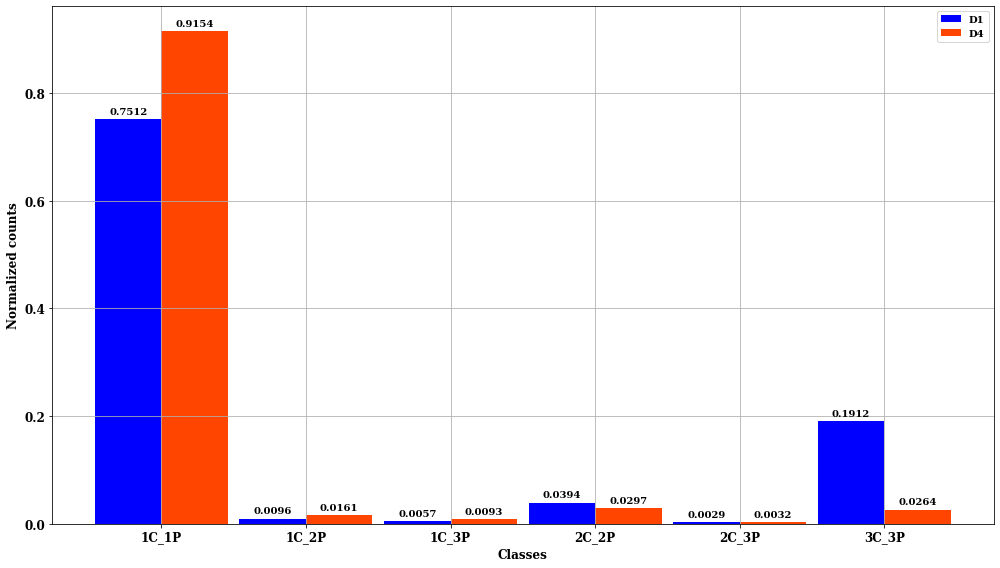

In [61]:
# fig, ax = plt.subplots(figsize=(16,10))
# rects1 = ax.bar(bins, D1_normalized,color='b',label='D1', align='center')
# rects2 = ax.bar(bins, D4_normalized,color='orangered',label='D4', align='center', alpha = 0.5)

#ind = np.arange(len(men_means))  # the x locations for the groups
width = 0.46  # the width of the bars

fig, ax = plt.subplots(figsize=(14,8))
rects_D1 = ax.bar(bins - width/2, hist_D1_normalized,width,color='b',label='D1')
rects_D4 = ax.bar(bins + width/2, hist_D4_normalized,width,color='orangered',label='D4')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Normalized counts')
ax.set_xlabel('Classes')
ax.set_xticks(bins)
ax.set_xticklabels(np.unique(cl_D1))
ax.grid()
ax.legend()


def autolabel(rects, xpos='center'):
    """
    Attach a text label above each bar in *rects*, displaying its height.

    *xpos* indicates which side to place the text w.r.t. the center of
    the bar. It can be one of the following {'center', 'right', 'left'}.
    """

    ha = {'center': 'center', 'right': 'left', 'left': 'right'}
    offset = {'center': 0, 'right': 1, 'left': -1}

    for rect in rects:
        height = rect.get_height()
        ax.annotate('{:.4f}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(offset[xpos]*3, 3),  # use 3 points offset
                    textcoords="offset points",  # in both directions
                    ha=ha[xpos], va='bottom')


autolabel(rects_D1, "center")
autolabel(rects_D4, "center")

fig.tight_layout()

plt.show()

In [62]:
data_boxplot_D1 = [edge_D1["Scores"].loc[edge_D1['Class'] == '1C_1P'],edge_D1["Scores"].loc[edge_D1['Class'] == '1C_2P'],edge_D1["Scores"].loc[edge_D1['Class'] == '1C_3P'],edge_D1["Scores"].loc[edge_D1['Class'] == '2C_2P'],edge_D1["Scores"].loc[edge_D1['Class'] == '2C_3P'],edge_D1["Scores"].loc[edge_D1['Class'] == '3C_3P']]

In [63]:
data_boxplot_D4 = [edge_D4["Scores"].loc[edge_D4['Class'] == '1C_1P'],edge_D4["Scores"].loc[edge_D4['Class'] == '1C_2P'],edge_D4["Scores"].loc[edge_D4['Class'] == '1C_3P'],edge_D4["Scores"].loc[edge_D4['Class'] == '2C_2P'],edge_D4["Scores"].loc[edge_D4['Class'] == '2C_3P'],edge_D4["Scores"].loc[edge_D4['Class'] == '3C_3P']]

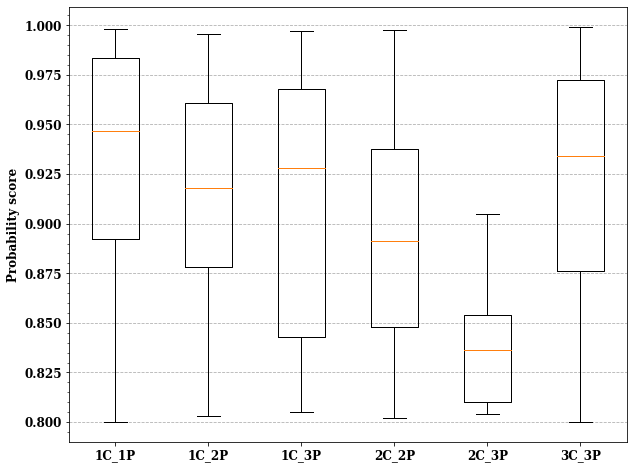

In [64]:
fig = plt.figure(1, figsize=(10,8))
ax = fig.add_subplot(111)
bp = ax.boxplot(data_boxplot_D1,whis=(0,100))
#plt.boxplot(df1_unique["scores"].loc[df1_unique['class'] == '1C_3P'])
ax.set_xticklabels(["1C_1P","1C_2P","1C_3P","2C_2P","2C_3P","3C_3P"])
ax.yaxis.set_minor_locator(AutoMinorLocator())
#plt.xticks()
ax.get_xaxis().tick_bottom()
ax.get_yaxis().tick_left()
#ax.set_xlabel('Classes')
ax.set_ylabel('Probability score')
ax.grid(which='major',linestyle='dashed',axis='y')
plt.show()

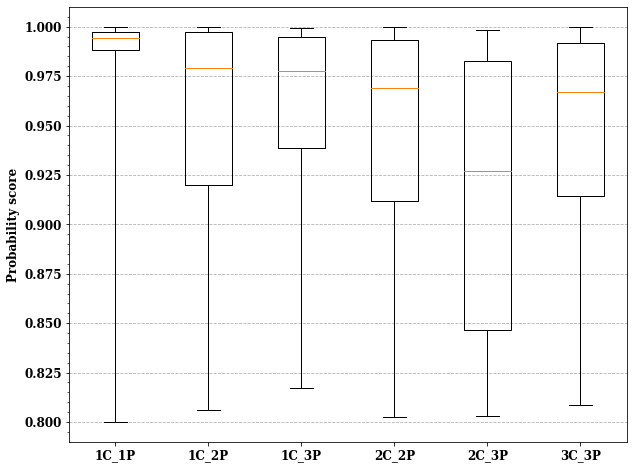

In [65]:
fig = plt.figure(1, figsize=(10,8))
ax = fig.add_subplot(111)
bp = ax.boxplot(data_boxplot_D4,whis=(0,100))
#plt.boxplot(df1_unique["scores"].loc[df1_unique['class'] == '1C_3P'])
ax.set_xticklabels(["1C_1P","1C_2P","1C_3P","2C_2P","2C_3P","3C_3P"])
ax.yaxis.set_minor_locator(AutoMinorLocator())
#plt.xticks()
ax.get_xaxis().tick_bottom()
ax.get_yaxis().tick_left()
#ax.set_xlabel('Classes')
ax.set_ylabel('Probability score')
ax.grid(which='major',linestyle='dashed',axis='y')
plt.show()

In [66]:
print("1st quartile (25%): {}, median (50%): {}, 3rd quartile: {}".format(np.percentile(data_boxplot_D4[0],25),np.median(data_boxplot_D4[0]),np.percentile(data_boxplot_D4[0],75)))

1st quartile (25%): 0.9883, median (50%): 0.9943, 3rd quartile: 0.9973


In [67]:
width = np.percentile(data_boxplot_D4[0],50) - np.percentile(data_boxplot_D4[0],25)

lower_bound = np.percentile(data_boxplot_D4[0],25) - 1.5*width
upper_bound = np.percentile(data_boxplot_D4[0],75) + 1.5*width

In [68]:
lower_bound,upper_bound

(0.9793, 1.0063)

In [69]:
ul_D1 = SkyCoord(edge_D1['x2'],edge_D1['y1'],frame='fk5',unit='deg')
lr_D1 = SkyCoord(edge_D1['x2'],edge_D1['y2'],frame='fk5',unit='deg')
    
ul_pix_D1 = ul_D1.to_pixel(wcsradio)
    #ul_y = hosts_overlay(0,ul_pix[1],181/2,181/2,-np.pi)
    #ul_pix = np.array([ul_pix[0],ul_y[1]])
    
lr_pix_D1 = lr_D1.to_pixel(wcsradio)
    #lr_y = hosts_overlay(0,lr_pix[1],181/2,181/2,-np.pi)
    #lr_pix = np.array([lr_pix[0],lr_y[1]])
    
w_D1 = abs(ul_pix_D1[0]-lr_pix_D1[0])
h_D1 = abs(ul_pix_D1[1]-lr_pix_D1[1])

In [70]:
ul_D4 = SkyCoord(edge_D4['x2'],edge_D4['y1'],frame='fk5',unit='deg')
lr_D4 = SkyCoord(edge_D4['x2'],edge_D4['y2'],frame='fk5',unit='deg')
    
ul_pix_D4 = ul_D4.to_pixel(wcsradio)
    #ul_y = hosts_overlay(0,ul_pix[1],181/2,181/2,-np.pi)
    #ul_pix = np.array([ul_pix[0],ul_y[1]])
    
lr_pix_D4 = lr_D4.to_pixel(wcsradio)
    #lr_y = hosts_overlay(0,lr_pix[1],181/2,181/2,-np.pi)
    #lr_pix = np.array([lr_pix[0],lr_y[1]])
    
w_D4 = abs(ul_pix_D4[0]-lr_pix_D4[0])
h_D4 = abs(ul_pix_D4[1]-lr_pix_D4[1])

In [71]:
dim_D1 = {"Class":edge_D1["Class"].values, "box_size":h_D1}
dim_D4 = {"Class":edge_D4["Class"].values, "box_size":h_D4}

In [72]:
df_dim_D1 = pd.DataFrame(dim_D1)
df_dim_D4 = pd.DataFrame(dim_D4)

In [73]:
dim_D4 = [df_dim_D4['box_size'].loc[df_dim_D4['Class'] == '1C_1P'],df_dim_D4['box_size'].loc[df_dim_D4['Class'] == '1C_2P'],df_dim_D4['box_size'].loc[df_dim_D4['Class'] == '1C_3P'],df_dim_D4['box_size'].loc[df_dim_D4['Class'] == '2C_2P'],df_dim_D4['box_size'].loc[df_dim_D4['Class'] == '2C_3P'],df_dim_D4['box_size'].loc[df_dim_D4['Class'] == '3C_3P']]

In [74]:
dim_D1 = [df_dim_D1['box_size'].loc[df_dim_D1['Class'] == '1C_1P'],df_dim_D1['box_size'].loc[df_dim_D1['Class'] == '1C_2P'],df_dim_D1['box_size'].loc[df_dim_D1['Class'] == '1C_3P'],df_dim_D1['box_size'].loc[df_dim_D1['Class'] == '2C_2P'],df_dim_D1['box_size'].loc[df_dim_D1['Class'] == '2C_3P'],df_dim_D1['box_size'].loc[df_dim_D1['Class'] == '3C_3P']]

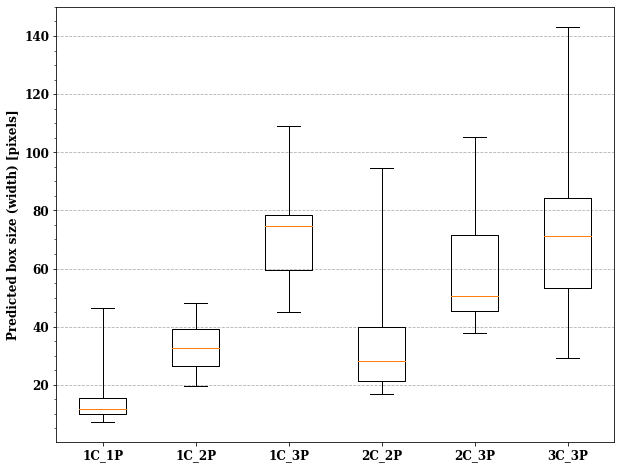

In [75]:
fig = plt.figure(1, figsize=(10,8))
ax = fig.add_subplot(111)
bp = ax.boxplot(dim_D1,whis=(0,100))
#plt.boxplot(df1_unique["scores"].loc[df1_unique['class'] == '1C_3P'])
ax.set_xticklabels(["1C_1P","1C_2P","1C_3P","2C_2P","2C_3P","3C_3P"])
ax.yaxis.set_minor_locator(AutoMinorLocator())
#plt.xticks()
ax.get_xaxis().tick_bottom()
ax.get_yaxis().tick_left()
#ax.set_xlabel('Classes')
ax.set_ylabel('Predicted box size (width) [pixels]')
ax.grid(which='major',linestyle='dashed',axis='y')
plt.show()

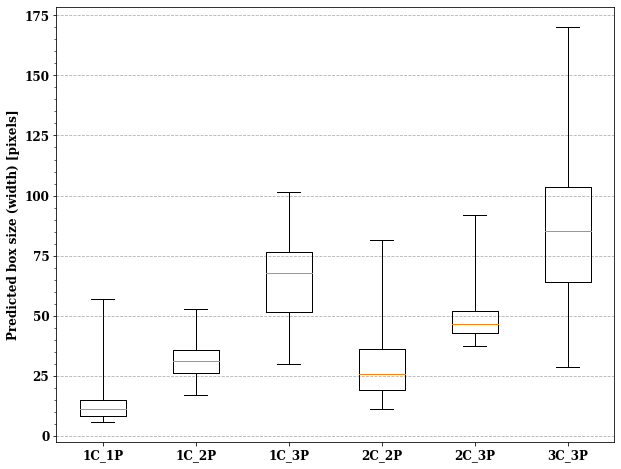

In [76]:
fig = plt.figure(1, figsize=(10,8))
ax = fig.add_subplot(111)
bp = ax.boxplot(dim_D4,whis=(0,100))
#plt.boxplot(df1_unique["scores"].loc[df1_unique['class'] == '1C_3P'])
ax.set_xticklabels(["1C_1P","1C_2P","1C_3P","2C_2P","2C_3P","3C_3P"])
ax.yaxis.set_minor_locator(AutoMinorLocator())
#plt.xticks()
ax.get_xaxis().tick_bottom()
ax.get_yaxis().tick_left()
#ax.set_xlabel('Classes')
ax.set_ylabel('Predicted box size (width) [pixels]')
ax.grid(which='major',linestyle='dashed',axis='y')
plt.show()

In [78]:
print("1st quartile (25%): {}, median (50%): {}, 3rd quartile: {}".format(np.percentile(dim_D4[2],25),np.median(dim_D4[2]),np.percentile(dim_D4[2],75)))

1st quartile (25%): 51.46635227295337, median (50%): 67.65580627065538, 3rd quartile: 76.6611241992241


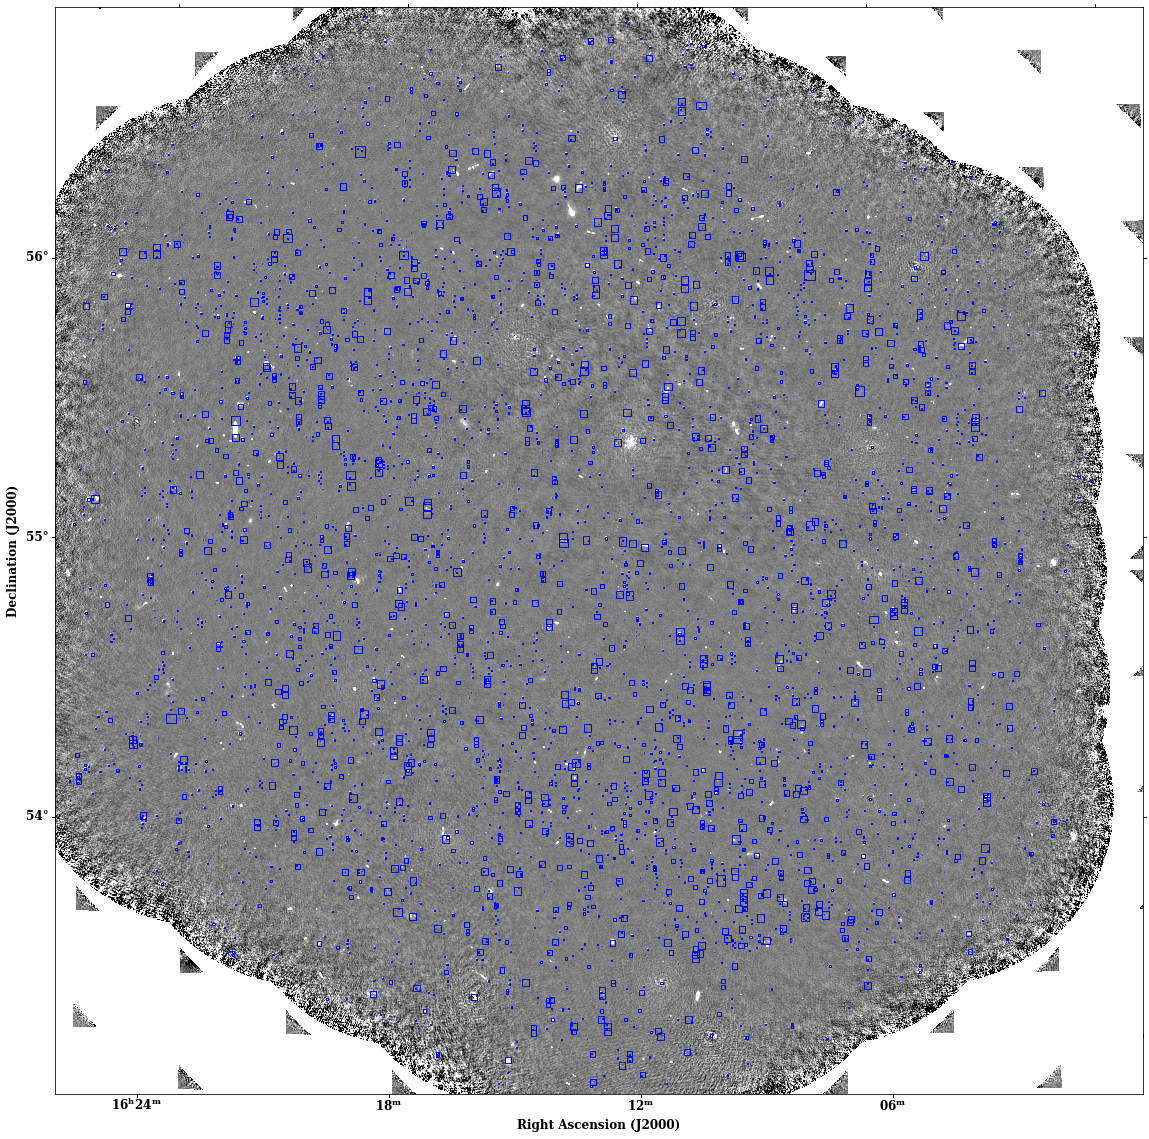

In [80]:
radio_file = 'gmrt_en1w610_clipped.fits'
hdu = fits.open(radio_file)[0]
wcsradio = WCS(hdu.header, naxis=2)

region = hdu.data[3200:10000, 1000:11000]


#roi = hdu.data[4200:4400, 1450:1750]

zmin_roi,zmax_roi = zscale(region)
#roi = regi

plt.figure(figsize=(20,20))
ax = plt.gca(projection=wcsradio)
#ax.subplot()
ax.imshow(hdu.data,cmap='gray', vmin=zmin_roi, vmax=zmax_roi, origin='lower')

#for ls in reg:
#    x = ls.to_pixel(wcsradio)
#    x.plot(ax=ax)
#plt.grid(color='white', ls='solid')
#ax.scatter(source_poss_pix[0],source_poss_pix[1],s=200,marker='.',label='Excluded FoV',facecolor='none',edgecolor='blue')
#ax.scatter(noclass_source_poss_pix[0],noclass_source_poss_pix[1],s=200,c='red',marker='+',label='No detection FoV')
#ax.legend(bbox_to_anchor=(1.04,0.5), loc="center left", fontsize=17, borderaxespad=0)
ax.set_xlabel('Right Ascension (J2000)')
ax.set_ylabel('Declination (J2000)')

#ax.add_artist(artist)

for i in range(len(edge_D1)):
#for i in range(1000):
    row = edge_D1.iloc[i]
    ul = SkyCoord(row['x1'],row['y1'],frame='fk5',unit='deg')
    lr = SkyCoord(row['x2'],row['y2'],frame='fk5',unit='deg')
    
    ul_pix = ul.to_pixel(wcsradio)
    #ul_y = hosts_overlay(0,ul_pix[1],181/2,181/2,-np.pi)
    #ul_pix = np.array([ul_pix[0],ul_y[1]])
    
    lr_pix = lr.to_pixel(wcsradio)
    #lr_y = hosts_overlay(0,lr_pix[1],181/2,181/2,-np.pi)
    #lr_pix = np.array([lr_pix[0],lr_y[1]])
    
    w = ul_pix[0]-lr_pix[0]
    h = ul_pix[1]-lr_pix[1]
    
    r = plt.Rectangle((lr_pix[0], lr_pix[1]), w, h, edgecolor='blue', facecolor='none')
    ax.add_patch(r)
               
#ax.annotate("", xy=(5858, 5758), xytext=(450, 1200),arrowprops=dict(arrowstyle="->"))
#ax.annotate("", xy=(9714, 3150), xytext=(750, 1000),arrowprops=dict(arrowstyle="->"))


#a = plt.axes([0.58, 0.45, 0.3, 0.3],projection=wcsradio)
#plt.subplot(projection=wcsradio)
#plt.imshow(roi,cmap='gray', vmin=zmin_roi, vmax=zmax_roi, origin='lower')


plt.show()

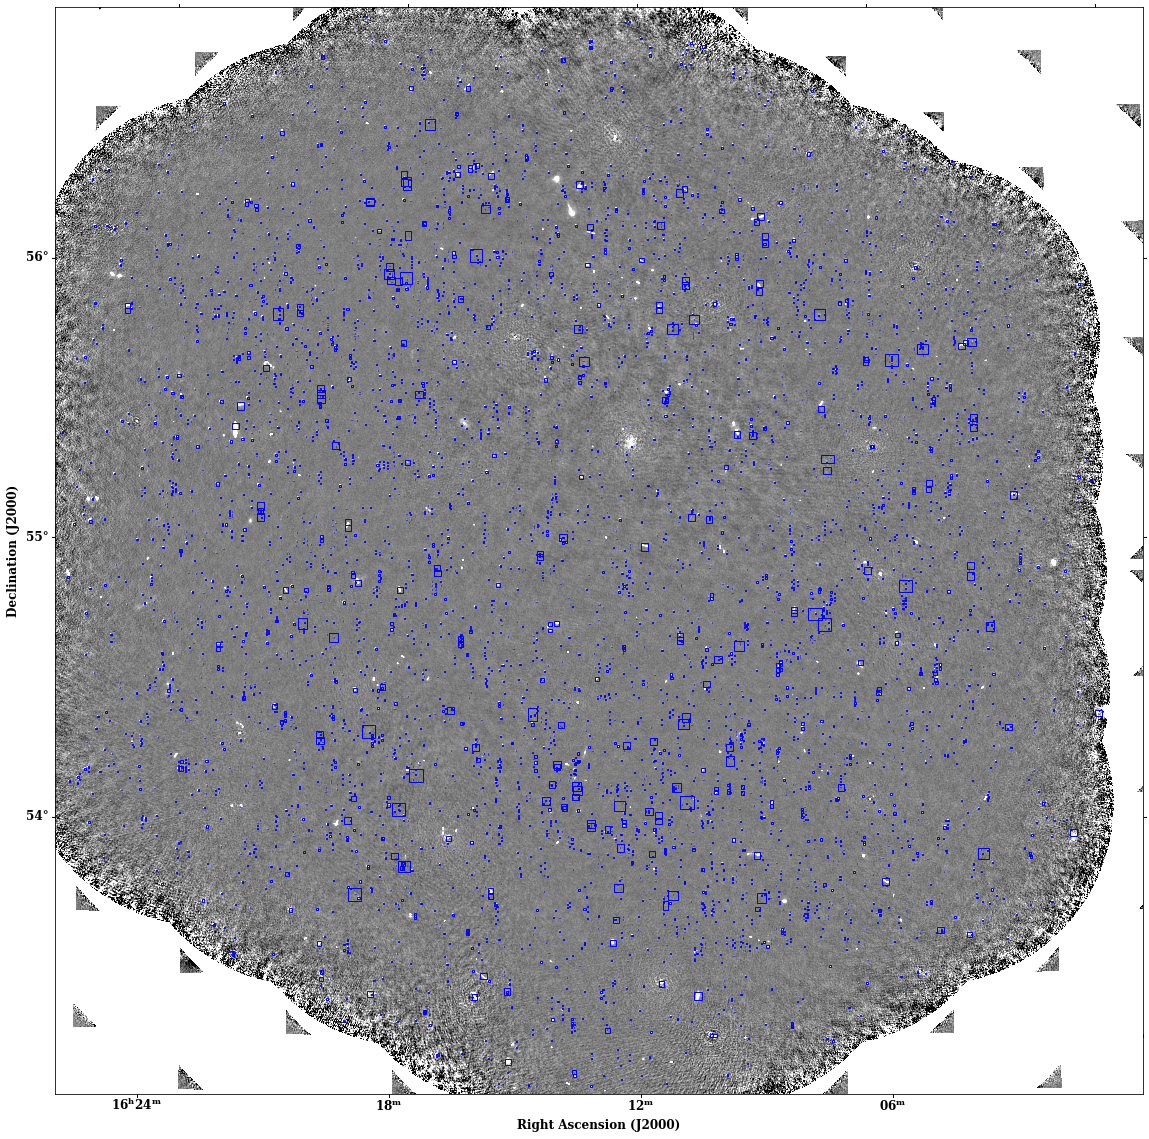

In [81]:
radio_file = 'gmrt_en1w610_clipped.fits'
hdu = fits.open(radio_file)[0]
wcsradio = WCS(hdu.header, naxis=2)

region = hdu.data[3200:10000, 1000:11000]


#roi = hdu.data[4200:4400, 1450:1750]

zmin_roi,zmax_roi = zscale(region)
#roi = regi

plt.figure(figsize=(20,20))
ax = plt.gca(projection=wcsradio)
#ax.subplot()
ax.imshow(hdu.data,cmap='gray', vmin=zmin_roi, vmax=zmax_roi, origin='lower')

#for ls in reg:
#    x = ls.to_pixel(wcsradio)
#    x.plot(ax=ax)
#plt.grid(color='white', ls='solid')
#ax.scatter(source_poss_pix[0],source_poss_pix[1],s=200,marker='.',label='Excluded FoV',facecolor='none',edgecolor='blue')
#ax.scatter(noclass_source_poss_pix[0],noclass_source_poss_pix[1],s=200,c='red',marker='+',label='No detection FoV')
#ax.legend(bbox_to_anchor=(1.04,0.5), loc="center left", fontsize=17, borderaxespad=0)
ax.set_xlabel('Right Ascension (J2000)')
ax.set_ylabel('Declination (J2000)')

#ax.add_artist(artist)

for i in range(len(edge_D4)):
#for i in range(1000):
    row = edge_D4.iloc[i]
    ul = SkyCoord(row['x1'],row['y1'],frame='fk5',unit='deg')
    lr = SkyCoord(row['x2'],row['y2'],frame='fk5',unit='deg')
    
    ul_pix = ul.to_pixel(wcsradio)
    #ul_y = hosts_overlay(0,ul_pix[1],181/2,181/2,-np.pi)
    #ul_pix = np.array([ul_pix[0],ul_y[1]])
    
    lr_pix = lr.to_pixel(wcsradio)
    #lr_y = hosts_overlay(0,lr_pix[1],181/2,181/2,-np.pi)
    #lr_pix = np.array([lr_pix[0],lr_y[1]])
    
    w = ul_pix[0]-lr_pix[0]
    h = ul_pix[1]-lr_pix[1]
    
    r = plt.Rectangle((lr_pix[0], lr_pix[1]), w, h, edgecolor='blue', facecolor='none')
    ax.add_patch(r)
               
#ax.annotate("", xy=(5858, 5758), xytext=(450, 1200),arrowprops=dict(arrowstyle="->"))
#ax.annotate("", xy=(9714, 3150), xytext=(750, 1000),arrowprops=dict(arrowstyle="->"))


#a = plt.axes([0.58, 0.45, 0.3, 0.3],projection=wcsradio)
#plt.subplot(projection=wcsradio)
#plt.imshow(roi,cmap='gray', vmin=zmin_roi, vmax=zmax_roi, origin='lower')


plt.show()

In [91]:
overlap_D4[92]

array([   88,    90,    91,    92,  2110,  2287,  2288,  3061,  3062,
        6943,  9661,  9662, 10659, 10660, 10661])

In [92]:
ex = data_D4.iloc[overlap_D4[92]]

In [99]:
ex

Source_ID  Class  Scores        x1       y1        x2       y2  \
88          1100  1C_1P  0.9962  245.0625  55.8979  245.0511  55.9048   
90          1100  1C_1P  0.9927  245.0879  55.9151  245.0849  55.9175   
91          1100  1C_1P  0.9899  245.0818  55.9222  245.0783  55.9246   
92          1100  3C_3P  0.9784  245.1170  55.8970  245.0518  55.9342   
2110        1067  1C_1P  0.9806  245.0881  55.9182  245.0844  55.9207   
2287        1110  1C_1P  0.9889  245.0884  55.9005  245.0849  55.9031   
2288        1110  1C_1P  0.9856  245.0811  55.9077  245.0784  55.9100   
3061        1127  1C_1P  0.9959  245.0815  55.9043  245.0761  55.9077   
3062        1127  1C_1P  0.9951  245.0570  55.8852  245.0476  55.8911   
6943        1186  1C_1P  0.8947  245.0571  55.8868  245.0491  55.8923   
9661        1152  1C_1P  0.9968  245.0569  55.8813  245.0475  55.8872   
9662        1152  1C_1P  0.9814  245.0824  55.9004  245.0775  55.9038   
10659       1107  1C_1P  0.9947  245.0868  55.8831  245.0838  55.8854   
10660       1107  1C_1P  0.9869  245.0594  55.9103  245.0502  55.9159   
10661       1107  1C_1P  0.9766  245.0806  55.8901  245.0772  55.8927   

          RC_RA   RC_Dec  PyBDSF_RA  PyBDSF_Dec  
88     245.0578  55.9008   245.0869     55.9159  
90     245.0869  55.9161   245.0869     55.9159  
91     245.0806  55.9234   245.0869     55.9159  
92     245.0617  55.9031   245.0869     55.9159  
2110   245.0870  55.9196   245.1146     55.9172  
2287   245.0866  55.9017   245.0800     55.9088  
2288   245.0801  55.9088   245.0800     55.9088  
3061   245.0799  55.9059   245.0539     55.8879  
3062   245.0539  55.8878   245.0539     55.8879  
6943   245.0494  55.8880   245.0139     55.9111  
9661   245.0533  55.8840   245.0386     55.8861  
9662   245.0798  55.9020   245.0386     55.8861  
10659  245.0854  55.8840   245.0816     55.9000  
10660  245.0549  55.9129   245.0816     55.9000  
10661  245.0791  55.8913   245.0816     55.9000

In [93]:
bbox = np.empty((0,5))

for i in range(len(ex)):
    
    row = ex.iloc[i]
    
    ul = SkyCoord(row['x1'],row['y1'],frame='fk5',unit='deg')
    lr = SkyCoord(row['x2'],row['y2'],frame='fk5',unit='deg')
    
    ul_pix = ul.to_pixel(wcsradio)

    
    lr_pix = lr.to_pixel(wcsradio)
    
    bbox = np.concatenate( ( bbox, [[ul_pix[0],ul_pix[1],lr_pix[0],lr_pix[1],row["Scores"]]] ) , axis=0)

In [94]:
bbox

array([[3.34124275e+03, 1.02797035e+04, 3.36488767e+03, 1.03039379e+04,
        9.96200000e-01],
       [3.29164572e+03, 1.03429318e+04, 3.29792429e+03, 1.03514088e+04,
        9.92700000e-01],
       [3.30462296e+03, 1.03681568e+04, 3.31190769e+03, 1.03766080e+04,
        9.89900000e-01],
       [3.23120873e+03, 1.02793580e+04, 3.36623202e+03, 1.04097651e+04,
        9.78400000e-01],
       [3.29153890e+03, 1.03540970e+04, 3.29923789e+03, 1.03628968e+04,
        9.80600000e-01],
       [3.28924112e+03, 1.02904232e+04, 3.29654963e+03, 1.02995934e+04,
        9.88900000e-01],
       [3.30465282e+03, 1.03159446e+04, 3.31031716e+03, 1.03240782e+04,
        9.85600000e-01],
       [3.30352212e+03, 1.03037315e+04, 3.31473718e+03, 1.03156809e+04,
        9.95900000e-01],
       [3.35114479e+03, 1.02337173e+04, 3.37066630e+03, 1.02544587e+04,
        9.95100000e-01],
       [3.35109336e+03, 1.02394799e+04, 3.36775194e+03, 1.02588546e+04,
        8.94700000e-01],
       [3.35098009e+03, 1.0219

In [95]:
non_max_suppression_fast(bbox[::3],0.3)

[0. 0. 1. 1.]
[0.]
[]


[1, 3, 4]

In [98]:
py_cpu_nms(bbox,0.3)

[10, 0, 7, 8, 12, 1, 2, 5, 13, 6, 11, 4, 3, 14]

The above two lines of code, show an example of applying nms suppression algorithm to get rid of overlapping detections. As shown on the first example, the algorithm retained only 3 boxes out of 15, whereas on the last example the other algorithm retained all detections. This behavior may be because of the overlapping threshold parameter passed to these algorithms. The reliability of this suppression algorithm for our course is yet to be explored.

In [100]:
# fused_extended = edge_D4[edge_D4["Class"]!='1C_1P']
# radio_extended = edge_D1[edge_D1["Class"]!='1C_1P']
fused_extended = data_D4[data_D4["Class"]!='1C_1P']
radio_extended = data_D1[data_D1["Class"]!='1C_1P']

In [101]:
match_ids_fused = []
match_ids_radio = []

for i in range(len(fused_extended)):
    
    row_fused = fused_extended.iloc[i]
    
    for j in range(len(radio_extended)):
        
        row_radio = radio_extended.iloc[j]
        
        if (row_fused['Source_ID']==row_radio['Source_ID'] and row_fused['Class']==row_fused['Class']):
            match_ids_fused.append(i)
            match_ids_radio.append(j)

In [102]:
len(np.array(match_ids_fused)),len(np.array(match_ids_radio))

(478, 478)

In [94]:
data_D4_match = fused_extended.iloc[(np.array(match_ids_fused))]
data_D1_match = radio_extended.iloc[(np.array(match_ids_radio))]

In [106]:
data_D1_match[data_D1_match["Class"]=='3C_3P'].sort_values(by="Source_ID")

Source_ID  Class  Scores        x1       y1        x2       y2  \
1532        210  3C_3P  0.9877  245.9559  54.5986  245.9341  54.6128   
1392        302  3C_3P  0.9461  245.8375  54.3883  245.8042  54.4088   
3419        812  3C_3P  0.9732  245.3472  56.0347  245.3138  56.0551   
3644        826  3C_3P  0.9841  245.3478  56.0162  245.3118  56.0383   
7463        888  3C_3P  0.8579  245.2134  54.3655  245.1895  54.3815   
...         ...    ...     ...       ...      ...       ...      ...   
6780       6156  3C_3P  0.9181  241.0270  53.6003  241.0024  53.6138   
5025       6172  3C_3P  0.9117  240.8856  55.7268  240.8470  55.7493   
4493       6184  3C_3P  0.9393  240.9357  54.8873  240.8895  54.9133   
1589       6207  3C_3P  0.9815  240.8986  55.4412  240.8508  55.4671   
6008       6211  3C_3P  0.9809  240.9014  55.4291  240.8525  55.4551   

         RC_RA   RC_Dec  PyBDSF_RA  PyBDSF_Dec  
1532  245.9458  54.6046   245.9511     54.6056  
1392  245.8237  54.4023   245.8266     54.4029  
3419  245.3313  56.0435   245.3373     56.0386  
3644  245.3305  56.0259   245.3252     56.0298  
7463  245.1994  54.3754   245.1983     54.3676  
...        ...      ...        ...         ...  
6780  241.0150  53.6070   241.0186     53.6069  
5025  240.8707  55.7400   240.8882     55.7326  
4493  240.9203  54.8973   240.9270     54.8966  
1589  240.8707  55.4490   240.8659     55.4464  
6008  240.8716  55.4372   240.8673     55.4405  

[140 rows x 11 columns]

In [107]:
data_D4_match[data_D4_match["Class"]=='3C_3P'].sort_values(by="Source_ID")

Source_ID  Class  Scores        x1       y1        x2       y2  \
6866         996  3C_3P  0.9972  245.1758  55.8458  245.1393  55.8673   
8513        1097  3C_3P  0.9971  245.0808  55.6405  245.0614  55.6529   
2865        1114  3C_3P  0.9983  245.0800  55.6406  245.0617  55.6519   
6627        1160  3C_3P  0.9124  245.0327  55.5156  244.9838  55.5453   
8109        1165  3C_3P  0.9734  244.9834  54.3167  244.9401  54.3436   
...          ...    ...     ...       ...      ...       ...      ...   
8028        6156  3C_3P  0.9854  241.0322  53.5988  241.0022  53.6150   
10752       6172  3C_3P  0.8930  240.9051  55.7270  240.8489  55.7537   
7642        6184  3C_3P  0.9649  240.9623  54.8748  240.9165  54.8998   
3204        6207  3C_3P  0.9711  240.9088  55.4432  240.8660  55.4653   
7812        6211  3C_3P  0.9354  240.9094  55.4310  240.8663  55.4537   

          RC_RA   RC_Dec  PyBDSF_RA  PyBDSF_Dec  
6866   245.1607  55.8551   245.1736     55.8476  
8513   245.0716  55.6477   245.0767     55.6459  
2865   245.0718  55.6471   245.0634     55.6460  
6627   245.0056  55.5288   245.0153     55.5398  
8109   244.9625  54.3300   244.9601     54.3309  
...         ...      ...        ...         ...  
8028   241.0197  53.6068   241.0186     53.6069  
10752  240.8720  55.7393   240.8882     55.7326  
7642   240.9365  54.8889   240.9270     54.8966  
3204   240.8821  55.4536   240.8659     55.4464  
7812   240.8801  55.4408   240.8673     55.4405  

[90 rows x 11 columns]

In [15]:
print("1C_1P - (D1, D4) : ({},{})".format(len(np.where(data_D1_match['Class']=='1C_1P')[0]),len(np.where(data_D4_match['Class']=='1C_1P')[0])))

1C_1P - (D1, D4) : (0,0)


In [95]:
print("1C_2P - (D1, D4) : ({},{})".format(len(np.where(data_D1_match['Class']=='1C_2P')[0]),len(np.where(data_D4_match['Class']=='1C_2P')[0])))

1C_2P - (D1, D4) : (37,49)


In [96]:
print("1C_3P - (D1, D4) : ({},{})".format(len(np.where(data_D1_match['Class']=='1C_3P')[0]),len(np.where(data_D4_match['Class']=='1C_3P')[0])))

1C_3P - (D1, D4) : (21,24)


In [97]:
print("2C_2P - (D1, D4) : ({},{})".format(len(np.where(data_D1_match['Class']=='2C_2P')[0]),len(np.where(data_D4_match['Class']=='2C_2P')[0])))

2C_2P - (D1, D4) : (68,112)


In [98]:
print("2C_3P - (D1, D4) : ({},{})".format(len(np.where(data_D1_match['Class']=='2C_3P')[0]),len(np.where(data_D4_match['Class']=='2C_3P')[0])))

2C_3P - (D1, D4) : (7,3)


In [99]:
print("3C_3P - (D1, D4) : ({},{})".format(len(np.where(data_D1_match['Class']=='3C_3P')[0]),len(np.where(data_D4_match['Class']=='3C_3P')[0])))

3C_3P - (D1, D4) : (121,66)
